# Order Book Data Collection (Binance)

## Objective
Collect order book snapshots from Binance to calibrate market impact model parameters.

**What we collect:**
- Bid/Ask prices and quantities at multiple levels
- Spread, liquidity metrics
- Order book imbalance

**Why we need this:**
- Estimate **ψ** (proportional costs) from spread
- Estimate **k** (permanent impact) via Kyle's lambda
- Estimate **η, φ** (temporary impact) by simulating market orders

---

## Data Source
- **API**: Binance Public REST API (no authentication required)
- **Endpoint**: `/api/v3/depth`
- **Rate limit**: 20 requests/second
- **Cost**: FREE ✅

---

# Setup

In [1]:
import requests
import pandas as pd
import numpy as np
from datetime import datetime
import time
import json
import os
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

# Graphics
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

print("✅ Imports successful")

✅ Imports successful


## Configuration

In [2]:
# ========== CONFIGURATION ==========

# Trading pair
SYMBOL = 'BTCUSDT'  # Change to 'ETHUSDT', 'BNBUSDT', etc.

# Collection parameters
DURATION_MINUTES = 60  # Total collection duration
INTERVAL_SECONDS = 10   # Time between snapshots
ORDERBOOK_DEPTH = 1000  # Number of price levels (max 5000)

# Output directory
OUTPUT_DIR = '../data/orderbook'

# ===================================

print(f"Configuration:")
print(f"  Symbol:           {SYMBOL}")
print(f"  Duration:         {DURATION_MINUTES} minutes")
print(f"  Interval:         {INTERVAL_SECONDS} seconds")
print(f"  Depth:            {ORDERBOOK_DEPTH} levels")
print(f"  Expected samples: {(DURATION_MINUTES * 60) // INTERVAL_SECONDS}")
print(f"  Output dir:       {OUTPUT_DIR}")

Configuration:
  Symbol:           BTCUSDT
  Duration:         60 minutes
  Interval:         10 seconds
  Depth:            1000 levels
  Expected samples: 360
  Output dir:       ../data/orderbook


---

# Helper Functions

In [3]:
def fetch_orderbook(symbol, limit=1000):
    """
    Fetch order book snapshot from Binance.
    
    Returns:
        dict with 'timestamp', 'bids', 'asks', 'lastUpdateId'
    """
    base_url = 'https://api.binance.com/api/v3'
    endpoint = f'{base_url}/depth'
    params = {'symbol': symbol, 'limit': limit}
    
    try:
        response = requests.get(endpoint, params=params, timeout=5)
        response.raise_for_status()
        data = response.json()
        
        return {
            'timestamp': datetime.now().isoformat(),
            'symbol': symbol,
            'bids': data['bids'],
            'asks': data['asks'],
            'lastUpdateId': data['lastUpdateId']
        }
    except requests.exceptions.RequestException as e:
        print(f"❌ Error fetching order book: {e}")
        return None

print("✅ Function defined: fetch_orderbook()")

✅ Function defined: fetch_orderbook()


In [4]:
def calculate_metrics(snapshot):
    """
    Calculate key metrics from order book snapshot.
    """
    bids = np.array(snapshot['bids'], dtype=float)
    asks = np.array(snapshot['asks'], dtype=float)
    
    if len(bids) == 0 or len(asks) == 0:
        return None
    
    best_bid = bids[0, 0]
    best_ask = asks[0, 0]
    mid_price = (best_bid + best_ask) / 2
    spread = best_ask - best_bid
    spread_bps = (spread / mid_price) * 10000
    
    # Liquidity at different depths
    bid_liq_10 = bids[:10, 1].sum()
    ask_liq_10 = asks[:10, 1].sum()
    bid_liq_100 = bids[:100, 1].sum() if len(bids) >= 100 else bids[:, 1].sum()
    ask_liq_100 = asks[:100, 1].sum() if len(asks) >= 100 else asks[:, 1].sum()
    
    # Order book imbalance
    total_bid_vol = bids[:, 1].sum()
    total_ask_vol = asks[:, 1].sum()
    imbalance = (total_bid_vol - total_ask_vol) / (total_bid_vol + total_ask_vol)
    
    return {
        'timestamp': snapshot['timestamp'],
        'mid_price': mid_price,
        'best_bid': best_bid,
        'best_ask': best_ask,
        'spread': spread,
        'spread_bps': spread_bps,
        'bid_liq_10': bid_liq_10,
        'ask_liq_10': ask_liq_10,
        'bid_liq_100': bid_liq_100,
        'ask_liq_100': ask_liq_100,
        'imbalance': imbalance
    }

print("✅ Function defined: calculate_metrics()")

✅ Function defined: calculate_metrics()


---

# Test Connection

In [5]:
# Test fetching a single snapshot
print(f"Testing connection to Binance API for {SYMBOL}...\n")

test_snapshot = fetch_orderbook(SYMBOL, limit=100)

if test_snapshot:
    print("✅ Connection successful!\n")
    
    # Display sample metrics
    metrics = calculate_metrics(test_snapshot)
    
    print("Sample metrics:")
    print(f"   Mid price:        ${metrics['mid_price']:,.2f}")
    print(f"   Best bid:         ${metrics['best_bid']:,.2f}")
    print(f"   Best ask:         ${metrics['best_ask']:,.2f}")
    print(f"   Spread:           ${metrics['spread']:.2f} ({metrics['spread_bps']:.2f} bps)")
    print(f"   Liquidity (top 10 bids): {metrics['bid_liq_10']:.2f} units")
    print(f"   Liquidity (top 10 asks): {metrics['ask_liq_10']:.2f} units")
    print(f"   Order book imbalance:    {metrics['imbalance']:+.4f}")
    
    print(f"\n📊 Order book depth:")
    print(f"   Bid levels: {len(test_snapshot['bids'])}")
    print(f"   Ask levels: {len(test_snapshot['asks'])}")
else:
    print("❌ Connection failed. Check your internet connection and symbol.")

Testing connection to Binance API for BTCUSDT...

✅ Connection successful!

Sample metrics:
   Mid price:        $89,888.90
   Best bid:         $89,888.90
   Best ask:         $89,888.91
   Spread:           $0.01 (0.00 bps)
   Liquidity (top 10 bids): 3.40 units
   Liquidity (top 10 asks): 0.76 units
   Order book imbalance:    +0.1347

📊 Order book depth:
   Bid levels: 100
   Ask levels: 100


---

# Data Collection

⚠️ **Note**: This will take `DURATION_MINUTES` to complete. You can interrupt it anytime with the stop button.

In [6]:
# Initialize storage
snapshots = []
metrics_list = []

num_snapshots = (DURATION_MINUTES * 60) // INTERVAL_SECONDS

print(f"🚀 Starting data collection...")
print(f"   Target: {num_snapshots} snapshots")
print(f"   Duration: ~{DURATION_MINUTES} minutes")
print(f"   You can stop anytime with the interrupt button\n")

start_time = time.time()

try:
    for i in range(num_snapshots):
        # Fetch snapshot
        snapshot = fetch_orderbook(SYMBOL, limit=ORDERBOOK_DEPTH)
        
        if snapshot:
            snapshots.append(snapshot)
            metrics = calculate_metrics(snapshot)
            if metrics:
                metrics_list.append(metrics)
            
            # Progress update every 10 snapshots
            if (i + 1) % 10 == 0:
                elapsed = time.time() - start_time
                remaining = (elapsed / (i + 1)) * (num_snapshots - i - 1)
                
                clear_output(wait=True)
                print(f"📊 Progress: {i+1}/{num_snapshots} snapshots")
                print(f"   Elapsed: {elapsed/60:.1f} min")
                print(f"   Remaining: ~{remaining/60:.1f} min")
                print(f"   Success rate: {len(snapshots)/(i+1)*100:.1f}%")
                
                if len(metrics_list) > 0:
                    latest = metrics_list[-1]
                    print(f"\n   Latest metrics:")
                    print(f"     Mid price: ${latest['mid_price']:,.2f}")
                    print(f"     Spread: {latest['spread_bps']:.2f} bps")
        
        # Wait before next snapshot
        time.sleep(INTERVAL_SECONDS)

except KeyboardInterrupt:
    print(f"\n⚠️ Collection interrupted by user")

print(f"\n✅ Collection complete!")
print(f"   Total snapshots: {len(snapshots)}")
print(f"   Total duration: {(time.time() - start_time)/60:.1f} minutes")

📊 Progress: 360/360 snapshots
   Elapsed: 62.1 min
   Remaining: ~0.0 min
   Success rate: 100.0%

   Latest metrics:
     Mid price: $89,672.68
     Spread: 0.00 bps

✅ Collection complete!
   Total snapshots: 360
   Total duration: 62.2 minutes


---

# Quick Analysis

📊 Summary Statistics:

          mid_price    spread_bps   imbalance
count    360.000000  3.600000e+02  360.000000
mean   89723.317028  1.114538e-03   -0.088517
std       58.441699  7.256054e-07    0.082548
min    89626.215000  1.112013e-03   -0.301509
25%    89680.442500  1.114058e-03   -0.151491
50%    89710.005000  1.114703e-03   -0.091476
75%    89761.965000  1.115070e-03   -0.026719
max    89927.015000  1.115745e-03    0.109332


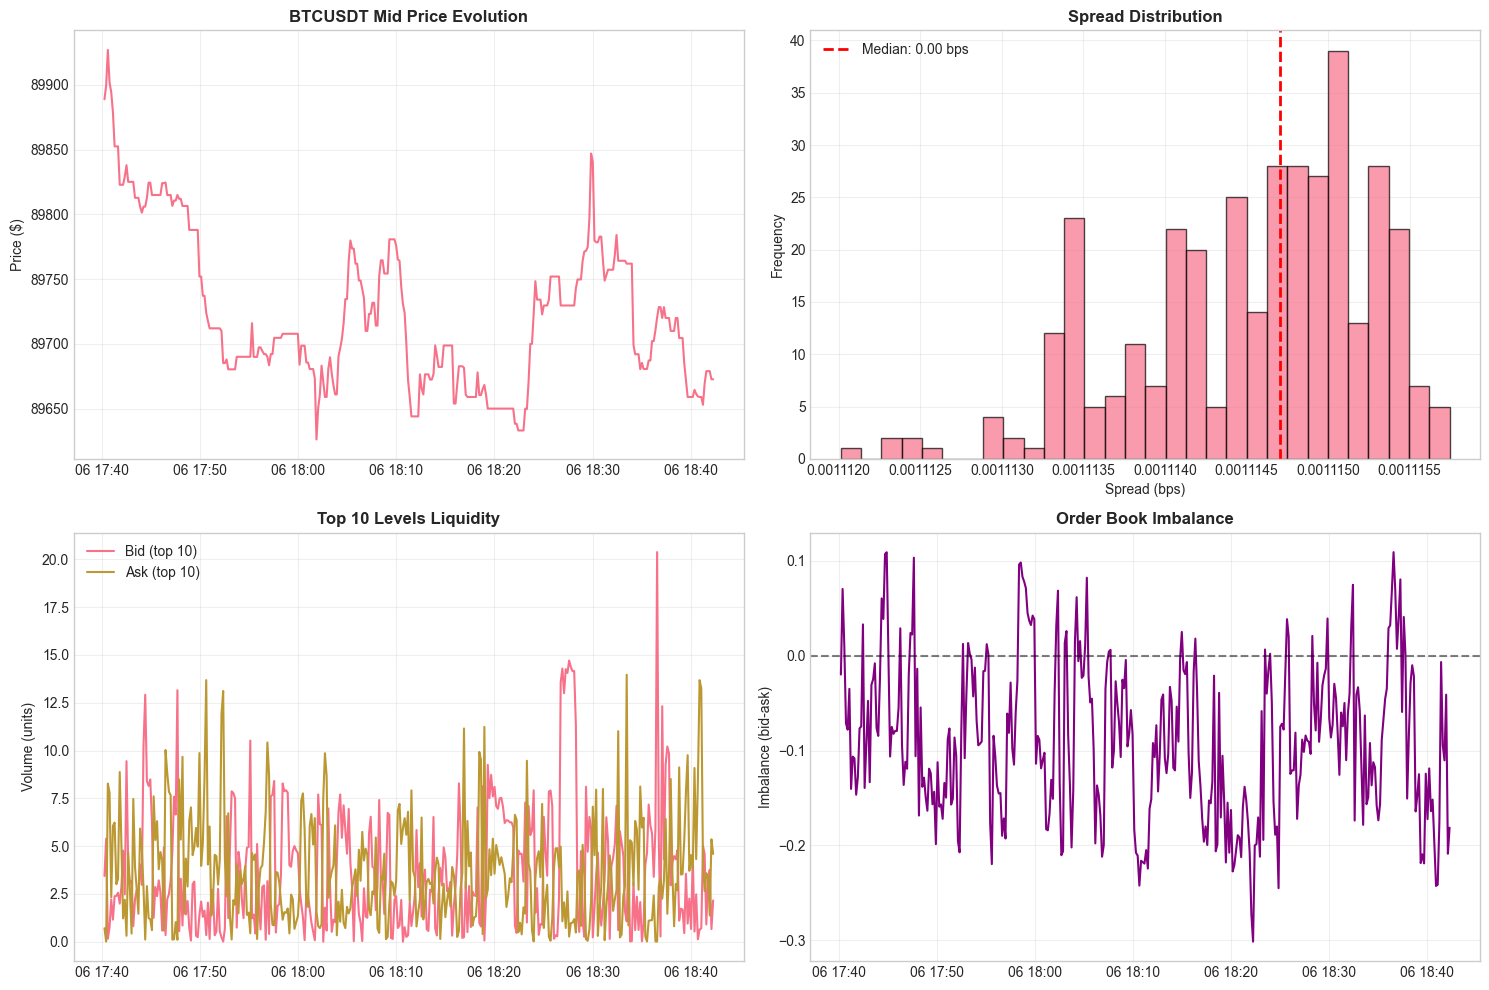


💡 Key insights:
   Average spread: 0.00 bps
   Median spread:  0.00 bps
   Price volatility: 58.44 (std dev)
   Average imbalance: -0.0885


In [7]:
if len(metrics_list) > 0:
    df_metrics = pd.DataFrame(metrics_list)
    df_metrics['timestamp'] = pd.to_datetime(df_metrics['timestamp'])
    df_metrics = df_metrics.set_index('timestamp')
    
    print("📊 Summary Statistics:\n")
    print(df_metrics[['mid_price', 'spread_bps', 'imbalance']].describe())
    
    # Visualizations
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # 1. Mid price evolution
    ax = axes[0, 0]
    ax.plot(df_metrics.index, df_metrics['mid_price'], linewidth=1.5)
    ax.set_title(f'{SYMBOL} Mid Price Evolution', fontweight='bold')
    ax.set_ylabel('Price ($)')
    ax.grid(True, alpha=0.3)
    
    # 2. Spread distribution
    ax = axes[0, 1]
    ax.hist(df_metrics['spread_bps'], bins=30, edgecolor='black', alpha=0.7)
    ax.axvline(df_metrics['spread_bps'].median(), color='red', linestyle='--', 
               linewidth=2, label=f"Median: {df_metrics['spread_bps'].median():.2f} bps")
    ax.set_title('Spread Distribution', fontweight='bold')
    ax.set_xlabel('Spread (bps)')
    ax.set_ylabel('Frequency')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 3. Liquidity over time
    ax = axes[1, 0]
    ax.plot(df_metrics.index, df_metrics['bid_liq_10'], label='Bid (top 10)', linewidth=1.5)
    ax.plot(df_metrics.index, df_metrics['ask_liq_10'], label='Ask (top 10)', linewidth=1.5)
    ax.set_title('Top 10 Levels Liquidity', fontweight='bold')
    ax.set_ylabel('Volume (units)')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 4. Order book imbalance
    ax = axes[1, 1]
    ax.plot(df_metrics.index, df_metrics['imbalance'], linewidth=1.5, color='purple')
    ax.axhline(0, color='black', linestyle='--', alpha=0.5)
    ax.set_title('Order Book Imbalance', fontweight='bold')
    ax.set_ylabel('Imbalance (bid-ask)')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n💡 Key insights:")
    print(f"   Average spread: {df_metrics['spread_bps'].mean():.2f} bps")
    print(f"   Median spread:  {df_metrics['spread_bps'].median():.2f} bps")
    print(f"   Price volatility: {df_metrics['mid_price'].std():.2f} (std dev)")
    print(f"   Average imbalance: {df_metrics['imbalance'].mean():+.4f}")
else:
    print("❌ No data collected")

---

# Save Data

In [8]:
if len(snapshots) > 0:
    # Create output directory
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    
    # Save raw snapshots
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    filename_raw = f'{OUTPUT_DIR}/{SYMBOL}_orderbook_{timestamp}.json'
    
    with open(filename_raw, 'w') as f:
        json.dump(snapshots, f, indent=2)
    
    print(f"✅ Raw snapshots saved to:")
    print(f"   {filename_raw}")
    print(f"   Size: {os.path.getsize(filename_raw) / 1024 / 1024:.2f} MB")
    
    # Save metrics as CSV
    if len(metrics_list) > 0:
        filename_metrics = f'{OUTPUT_DIR}/{SYMBOL}_metrics_{timestamp}.csv'
        df_metrics.to_csv(filename_metrics)
        
        print(f"\n✅ Metrics saved to:")
        print(f"   {filename_metrics}")
    
    print(f"\n🎯 Next step: Run notebook 06_parameter_calibration.ipynb")
else:
    print("❌ No data to save")

✅ Raw snapshots saved to:
   ../data/orderbook/BTCUSDT_orderbook_20251206_184228.json
   Size: 44.00 MB

✅ Metrics saved to:
   ../data/orderbook/BTCUSDT_metrics_20251206_184228.csv

🎯 Next step: Run notebook 06_parameter_calibration.ipynb
